In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import re
from rapidfuzz import fuzz
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Loading the csv file (open source)
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
print(df['message'].isnull().sum())
# no need to replace anything with anything since there are no missing values

0


In [4]:
# preprocessing the data either ways to make it easier
def preprocessing(text):
    if isinstance(text, str):
        return text.strip().lower()
    return "" 


     label                                            message
5630   ham  Mobikwik cashback of ₹30 has been credited to ...
5631   ham  Blinkit delivery partner is picking up your it...
5632   ham  Google Pay: Your transaction of ₹599 to Myntra...
5633   ham  Airtel: Your plan is valid until next month. D...
5634   ham  Your SBI debit card has been delivered. Please...


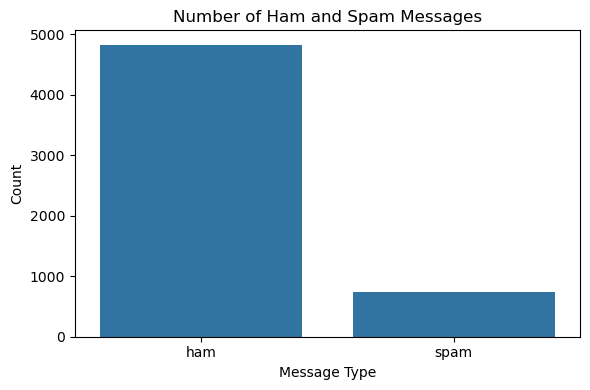

In [5]:
# Since the dataset was created in 2016 , it is no longer suitable for current spam message training hence we add additional spam and ham so tht the 
# model can be trained with updated spam messages (until we find a better dataset)
synthetic_spam = [
    "Hurry up! Spin the wheel and win amazing prizes today!",
    "Don't miss out, click this link below to claim your exclusive offer.",
    "Congratulations! Claim your prize now by visiting our website.",
    "Spin the wheel for a chance to win big rewards instantly.",
    "Click this link below to activate your free gift card.",
    "Limited time offer: claim your prize before it expires!",
    "Your Paytm KYC is pending. Visit paytm-help.xyz to update immediately or your wallet will be blocked.",
    "Dear SBI customer, your YONO access is suspended. Reactivate now at sbi-verify.info.",
    "Your Flipkart order has been held. Verify payment details at flipkart-secure.in.",
    "Claim your ICICI refund now at icici-alerts.co before it expires.",
    "Congratulations! You’ve won ₹10,000 Amazon Pay balance. Click amazon-india-reward.co to claim.",
    "Your HDFC NetBanking is temporarily disabled. Restore access at hdfc-login.help.",
    "Dear customer, you've received cashback from PhonePe. Claim it here: phonepe-promos.co.",
    "URGENT: Complete your KYC at google-pay.in-gov.org or services will be paused.",
    "Netflix account will be suspended. Update billing info at netflix-india-check.com.",
    "Verify your IRCTC account to avoid suspension. Visit irctc-securemail.in now.",
    "Zomato order refund of ₹145 is pending. Confirm your bank details here: zomato-service.co.",
    "Your LIC policy is expiring. Renew now at lic-india-secure.org.",
    "New cashback reward from Swiggy! Click swiggyoffers.today to activate.",
    "You've won a Flipkart voucher worth ₹5,000! Visit luckyflipkart.win to claim.",
    "Exclusive Myntra promo! Get ₹1,000 free. Redeem at myntra-gift.xyz now.",
    "Your Uber account has a pending verification. Go to uberindia-check.net.",
    "EPFO alert: Your UAN is deactivated. Update now at epfo-portal.live.",
    "BigBasket gift card awaits! Collect it now at bigbasket-prizes.co.",
    "Get your free Amazon Fire Stick now. Just pay ₹2 shipping at amznindia.click.",
    "Your PAN is under review. Verify at incometax-kyc.co.in to avoid penalties.",
    "Disney+ Hotstar subscription renewal failed. Update payment at hotstar-secure.org.",
    "Airtel cashback alert! Grab ₹100 now at airtel-verification.in.",
    "Mobikwik KYC expired! Update immediately at mobikwik-verify.net.",
    "Your Ola ride history is locked. Unlock it now at ola-securitycheck.com.",
    "Congratulations! You won ₹25,000 in the Dream11 IPL draw. Visit dream11-rewards.win to claim.",
    "Claim your bonus on WinZO now! Tap winzo-bonus.live before midnight."
]

synthetic_ham = [
    "I was thinking we could spin the wheel at the party for fun.",
    "Please click this link below to view the meeting agenda.",
    "Remember to claim your prize for participating in the office raffle.",
    "Let's schedule a meeting and discuss the project details.",
    "Can you spin the wheel for the game tonight?",
    "Here is the link below that contains the report you asked for.",
    "Your Paytm wallet balance is low. Please add funds to continue using services.",
    "ICICI sent a transaction alert for your recent payment. Kindly check your inbox.",
    "Flipkart delivery scheduled for today. Track your order via the Flipkart app.",
    "Reminder: Your LIC premium is due next week. Please pay via official website.",
    "Your Swiggy order is on the way. Estimated delivery in 30 minutes.",
    "Your Ola driver is arriving soon. Please be at the pickup point.",
    "Netflix: Enjoy your favorite shows. Your subscription is active till June 30.",
    "Zomato feedback request: How was your recent order?",
    "Amazon: Your refund of ₹499 has been initiated. No action required.",
    "PhonePe: Payment of ₹250 to Electric Co. was successful.",
    "Uber: You’ve earned a ₹100 ride credit valid for this week.",
    "Jio recharge of ₹239 is successful. Enjoy unlimited calls and 1.5GB/day.",
    "Ajio return request has been received. Pickup scheduled for tomorrow.",
    "HDFC: Your credit card statement is ready to view in NetBanking.",
    "Hotstar: New episode of your favorite series is now streaming!",
    "SBI: Your OTP for internet banking login is 457321. Do not share it.",
    "IRCTC: Train 12345 is expected to arrive at 6:45 PM. Check platform info in app.",
    "Income Tax India: Reminder to file your ITR before July 31.",
    "BigBasket: Your order #BB1234567 has been packed and ready for dispatch.",
    "BookMyShow: Your tickets for 'Avengers' have been emailed to you.",
    "Mobikwik cashback of ₹30 has been credited to your wallet.",
    "Blinkit delivery partner is picking up your items. Track live in app.",
    "Google Pay: Your transaction of ₹599 to Myntra was successful.",
    "Airtel: Your plan is valid until next month. Data left: 3.2 GB.",
    "Your SBI debit card has been delivered. Please activate via YONO app."
]

df_synthetic_spam = pd.DataFrame({
    'message': synthetic_spam,
    'label': ['spam'] * len(synthetic_spam)
})

df_synthetic_ham = pd.DataFrame({
    'message': synthetic_ham,
    'label': ['ham'] * len(synthetic_ham)
})

# Append to your original dataset
df_augmented = pd.concat([df, df_synthetic_spam, df_synthetic_ham], ignore_index=True)
print(df_augmented.tail())
# successfully augmented


In [6]:
# applying the preprocessing after addition of synthetic messages
df['message'] = df['message'].apply(preprocessing)
df.head()

,label,message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [9]:
l = LabelEncoder()
y = l.fit_transform(df_augmented['label'])  # 0 = ham, 1 = spam
X = df_augmented['message']

# Save label encoder for Streamlit app
joblib.dump(l, "msg_label_encoder.pkl")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and train pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english')),
    ('clf', SVC(kernel='linear', probability=True))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Save the trained pipeline
joblib.dump(pipeline, "svm_message_pipeline.pkl")

['svm_message_pipeline.pkl']

In [10]:

accuracy_score(y_test,y_pred)

0.9816676522767593

In [11]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[1441,   16],
       [  15,  219]])

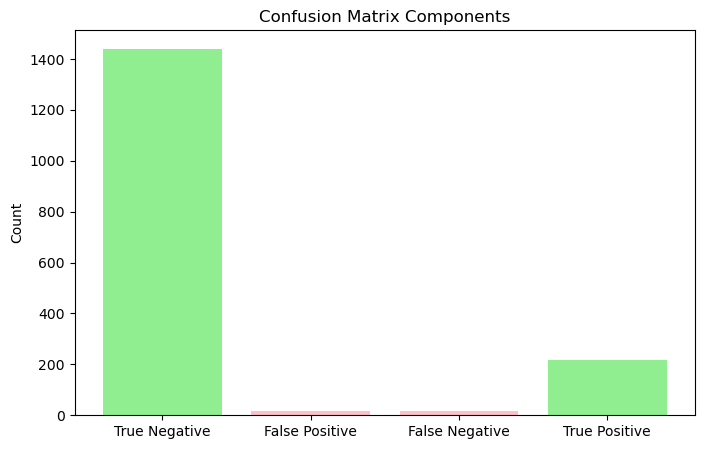

In [12]:
TP = 219
TN = 1441
FP = 16
FN = 15

labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [TN, FP, FN, TP]

plt.figure(figsize=(8,5))
plt.bar(labels, counts, color=['lightgreen', 'pink', 'pink', 'lightgreen'])
plt.title('Confusion Matrix Components')
plt.ylabel('Count')
plt.show()

In [13]:
# Load dataset
url_df = pd.read_csv('malicious_phish.csv')

# Group 'phishing' and 'defacement' as 'scam', 'benign' as 'benign'
url_df['label_grouped'] = url_df['type'].replace({'phishing': 'scam', 'defacement': 'scam', 'benign': 'benign'})

# Encode labels using LabelEncoder
le = LabelEncoder()
url_df['label_encoded'] = le.fit_transform(url_df['label_grouped'])

# Features and target
X = url_df['url']
y = url_df['label_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline with TF-IDF vectorizer (limit features) + LinearSVC (faster than SVC)
url_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC())
])

# Train the model
url_pipeline.fit(X_train, y_train)

# Save the pipeline and the label encoder
joblib.dump(url_pipeline, "svm_url_pipeline.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [14]:
url_pipeline = joblib.load("svm_url_pipeline.pkl")
message_pipeline = joblib.load("svm_message_pipeline.pkl")
phishing_targets = pd.read_csv("phishing_targets.csv")['label'].str.lower().tolist()

def is_brand_impersonation(url, label, threshold=80):
    url_lower = url.lower()
    for brand in brands:
        score = fuzz.partial_ratio(label, url_lower)
        if score >= threshold:
            return True
    return False

def detect_scam(message):
    url_pattern = r'https?://\S+|www\.\S+'
    urls = re.findall(url_pattern, message)
    
    if urls:
        for url in urls:
            if is_brand_impersonation(url, phishing_targets):
                return "Scam (Brand Impersonation)"
            
            pred = url_pipeline.predict([url])[0]
            if pred == 1:
                return "Scam (Malicious URL)"
        
        return "Not Scam"
    else:
        pred = message_pipeline.predict([message])[0]
        return "Scam (Text Classifier)" if pred == 1 else "Not Scam"

Accuracy: 0.9370
[[126207     68   2458]
 [   351   8809    539]
 [  8781    109  48036]]


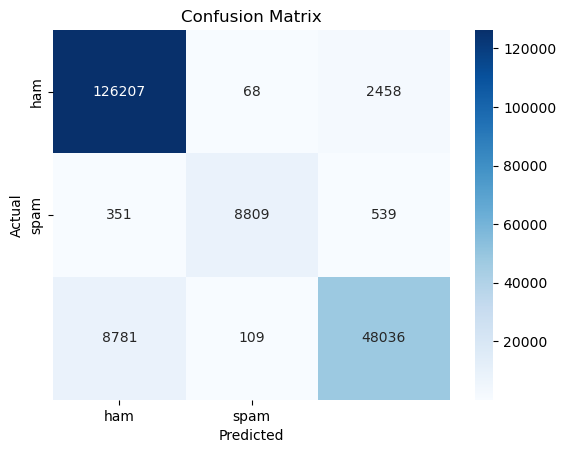

In [15]:
y_test_pred = url_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
labels = l.classes_ 
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print("Original types:", url_df['type'].unique())
print("After grouping:", url_df['label_grouped'].unique())


Original types: ['phishing' 'benign' 'defacement' 'malware']
After grouping: ['scam' 'benign' 'malware']


In [17]:
url2 = "paypal-support-login.com"
phishing_targets2 = ['paypal', 'amazon', 'google', 'microsoft']

def is_brand_impersonation(url, brands, threshold=80):
    url_lower = url.lower()
    for brand in brands:
        score = fuzz.partial_ratio(brand, url_lower)
        print(f"Checking brand '{brand}' against URL -> Score: {score}")
        if score >= threshold:
            return True
    return False

print(is_brand_impersonation(url2, phishing_targets2))

Checking brand 'paypal' against URL -> Score: 100.0
True
